In [17]:
import os
import sys
from chordUtils import json2lab
from subprocess import call
import json
import argparse
import chordUtils
import essentia.standard
import vamp
import numpy as np
import re
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from scipy.misc import logsumexp

sns.set(style="white", context="talk")
degrees=['I', 'IIb', 'II', 'IIIb', 'III', 'IV', 'Vb', 'V', 'VIb', 'VI', 'VIIb', 'VII']

def logNormalize(chromas):
    #data=preprocessing.normalize(chromas)
    #  data=np.log(preprocessing.normalize(chromas, norm='l1'))
    data=preprocessing.normalize(chromas, norm='l1')

    # '/1000' is a hack in order to eliminate zero deviation.
    data[data < -2.0] = data[data < -2.0]/10000.0-5
    data[np.isnan(data)] = -5
    data[np.isinf(data)] = -5

    return data

In [18]:
def fitMixture(data, max_components=40, min_components=1):
    bic = 1000000
    bic_i = 0
    for i in range(min_components, max_components):
        gm = GaussianMixture(
            n_components=i, covariance_type='full',
            max_iter=200,
            random_state = 8)
        gm.fit(data)
        curBic = gm.bic(data)
        print i, curBic, gm.converged_
        if (curBic < bic):
            bic = curBic
            bic_i = i
        #print gm.weights_
    gm = GaussianMixture(
        n_components=bic_i, covariance_type='full',
        max_iter=200,
        random_state = 8)
    gm.fit(data)
    return gm

# Guitar "toy" dataset. Major triad.

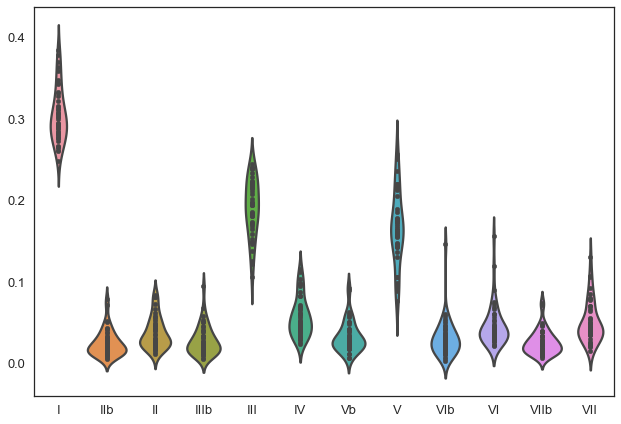

In [19]:
chromas, labels, kinds, mbids, start_times, durations = chordUtils.loadDatasetChroma('../guitar35.npz')
chromas = logNormalize(chromas)
dMaj = pd.DataFrame(data=chromas[kinds =='maj'], columns=degrees)
dMaj < 0
sns.violinplot(data=dMaj, inner="point")
plt.show()

# Guitar "toy" dataset. Major mixture (triad, maj7, maj6, maj69).

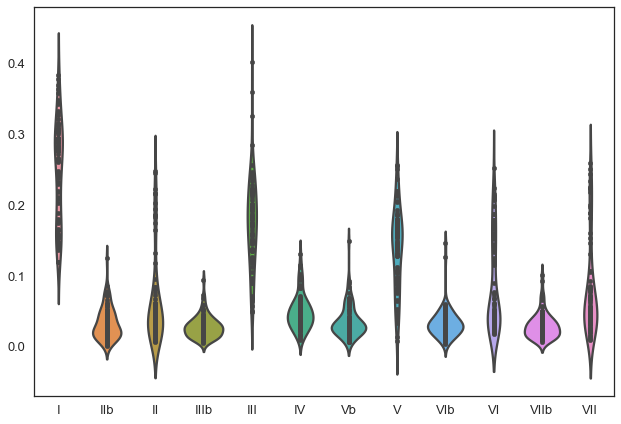

In [20]:
chromas, labels, kinds, mbids, start_times, durations = chordUtils.loadDatasetChroma('../guitar.npz')
chromas = logNormalize(chromas)
dMaj = pd.DataFrame(data=chromas[kinds =='maj'], columns=degrees)
sns.violinplot(data=dMaj, inner="point")
plt.show()

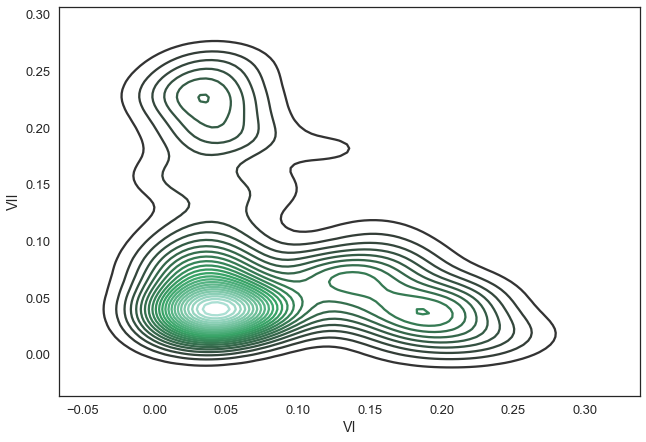

In [21]:
sns.kdeplot(dMaj['VI'], dMaj['VII'], n_levels=30)
plt.show()

1 -4617.75760271 True
2 -4482.91167285 True
3 -4272.88021731 True
4 -4136.31371646 True
5 -3964.21663486 True
6 -3777.71437333 True
7 -3635.10729925 True
8 -3587.75607826 True
9 -3508.88965531 True
10 -3300.05824179 True
11 -3029.94244968 True
12 -2927.13872599 True
13 -2584.86586608 True
14 -2276.46606016 True
15 -2039.82000861 True
16 -1880.34156922 True
17 -1567.62991981 True
18 -1299.6399163 True
19 -927.65326675 True
20 -657.117333551 True
21 -280.040315556 True
22 1.25527234882 True
23 237.557032837 True
24 454.300035891 True
25 777.682746148 True
26 1114.62009016 True
27 1314.02756778 True
28 1690.51150607 True
29 2128.10635123 True
30 2504.91651549 True
31 2816.94832445 True
32 3208.49094031 True
33 3599.95384957 True
34 3909.38317988 True
35 4281.84329169 True
36 4680.75095788 True
37 5049.77959218 True
38 5428.93816239 True
39 5806.91275367 True
True
-4617.75760271
[ 1.]


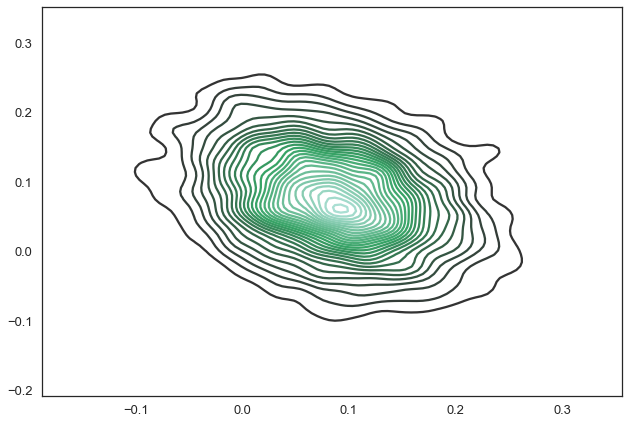

In [22]:
initialMeans = np.array([[1.0, -5.0, -5.0, -5.0, 1.0, -5.0, -5.0, 1.0, -5.0, -5.0,-5.0, 1.0],
                        [1.0, -5.0, 1.0, -5.0, 1.0, -5.0, -5.0, 0.0, 0.0, 1.0, -5.0, -5.0],
                        [1.0, -5.0, -5.0, -5.0, 1.0, -5.0, -5.0, 0.0, -5.0, 1.0, -5.0, -5.0],
                        [1.0, -5.0, -5.0, -5.0, 1.0, -5.0, -5.0, 1.0, -5.0, -5.0, -5.0, -5.0]])
initialWeights = np.array([0.25, 0.25, 0.25, 0.25])
#for i in range(1, 21):
gm = fitMixture(dMaj.values)
#gm = GaussianMixture(
#    n_components=6, covariance_type='full',
#    max_iter=200,
#    random_state = 8)
#gm.fit(dMaj.values)
print gm.converged_
print gm.bic(dMaj)
print gm.weights_
samples = np.asarray(gm.sample(4000)[0])
samples[:,[9, 11]].shape
sns.kdeplot(samples[:,[9, 11]], n_levels=30)
plt.show()
majorMeans = gm.means_

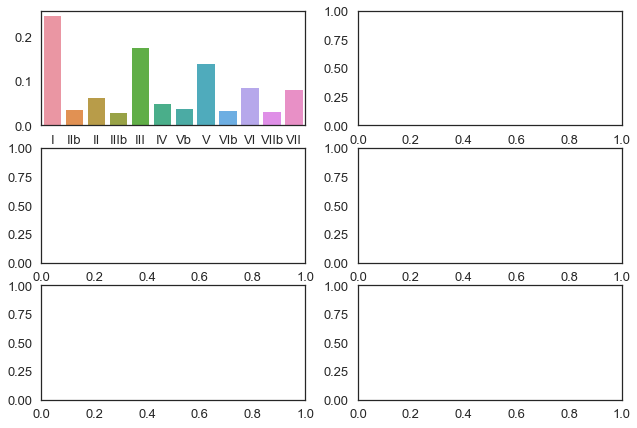

,I,IIb,II,IIIb,III,IV,Vb,V,VIb,VI,VIIb,VII
0,0.246882,0.033693,0.063074,0.028639,0.176447,0.049454,0.036453,0.138636,0.033439,0.083906,0.030172,0.079206


In [23]:
fig, ax = plt.subplots(nrows=3,ncols=2)
ax = np.reshape(np.array(ax), (1, np.size(ax)))[0]


for i in range(len(gm.means_)):
  sns.barplot(degrees,gm.means_[i], ax=ax[i])

plt.show()

df = pd.DataFrame(gm.means_, columns=degrees)
df

# Jazz dataset. Tunes considered so far:

In [24]:
with open('../ready.txt') as f:
      lines = f.readlines()
      print len(lines)
      print "\r".join(lines)

33
annotations/in_a_mellotone.json
annotations/swing_that_music.json
annotations/body_and_soul(hawkins).json
annotations/parkers_mood.json
annotations/west_end_blues.json
annotations/mean_to_me.json
annotations/minor_swing.json
annotations/st_thomas.json
annotations/dippermouth_blues.json
annotations/livery_stable_blues.json
annotations/i_found_a_new_baby.json
annotations/blue_horizon.json
annotations/tricotism.json
annotations/girl_from_ipanema.json
annotations/giant_steps.json
annotations/dinah.json
annotations/dinah_red_nichols.json
annotations/east_st_louis.json
annotations/cotton_tail.json
annotations/one_oclock_jump.json
annotations/these_foolish_things.json
annotations/hotter_than_that.json
annotations/potato_head_blues.json
annotations/black_bottom_stomp.json
annotations/king_porter_stomp.json
annotations/i_got_rhythm.json
annotations/dinah_fats_waller.json
annotations/west_coast_blues.json
annotations/black_and_tan_fantasy.json
annotations/walkin_shoes.json
annotations/honeysu

In [25]:
chromas, labels, kinds, mbids, start_times, durations = chordUtils.loadDatasetChroma('../out.npz')
    chromas=logNormalize(chromas)
    dMaj = pd.DataFrame(data=chromas[kinds == 'maj'], columns=degrees)
    dMin = pd.DataFrame(data=chromas[kinds == 'min'], columns=degrees)
    dDom = pd.DataFrame(data=chromas[kinds == 'dom'], columns=degrees)
    dHdim = pd.DataFrame(data=chromas[kinds == 'hdim7'], columns=degrees)
    dDim = pd.DataFrame(data=chromas[kinds == 'dim'], columns=degrees)
    totalDuration = np.sum(durations)
    majDuration=sum(durations[kinds == 'maj'])
    minDuration=sum(durations[kinds == 'min'])
    domDuration=sum(durations[kinds == 'dom'])
    hdimDuration=sum(durations[kinds == 'hdim7'])
    dimDuration=sum(durations[kinds == 'dim'])

# Chord kind frequency. TODO: add more hdim7 (minor tunes)

In [26]:
print "Maj: ", len(dMaj), '(', len(dMaj) * 100.0 /len(chromas), '%) beats, ',majDuration,\
'(', majDuration*100.0/totalDuration, '%) sec'
print "Min: ", len(dMin), '(', len(dMin) * 100.0 /len(chromas), '%) beats, ',minDuration, 'sec',\
'(', minDuration*100.0/totalDuration, '%) sec'
print "Dom: ", len(dDom), '(', len(dDom) * 100.0 /len(chromas), '%) beats, ',domDuration, 'sec',\
'(', domDuration*100.0/totalDuration, '%) sec'
print "Hdim7: ", len(dHdim), '(', len(dHdim) * 100.0 /len(chromas), '%) beats, ',hdimDuration, 'sec',\
'(', hdimDuration*100.0/totalDuration, '%) sec'
print "Dim7: ", len(dDim), '(', len(dDim) * 100.0 /len(chromas), '%) beats, ',dimDuration, 'sec',\
'(', dimDuration*100.0/totalDuration, '%) sec'

Maj:  6884 ( 34.676606891 %) beats,  2413.5850041 ( 34.2904396863 %) sec
Min:  3358 ( 16.9151722748 %) beats,  1172.67400002 sec ( 16.6604892727 %) sec
Dom:  7781 ( 39.1950433206 %) beats,  2709.55100311 sec ( 38.4953068119 %) sec
Hdim7:  150 ( 0.755591376184 %) beats,  60.3800000548 sec ( 0.857834609772 %) sec
Dim7:  576 ( 2.90147088455 %) beats,  195.149999857 sec ( 2.7725475956 %) sec


# Unclassified.

In [27]:
unclassified = labels[kinds == 'unclassified']
Counter(unclassified).most_common(100)

[('N', 1103)]

# Major

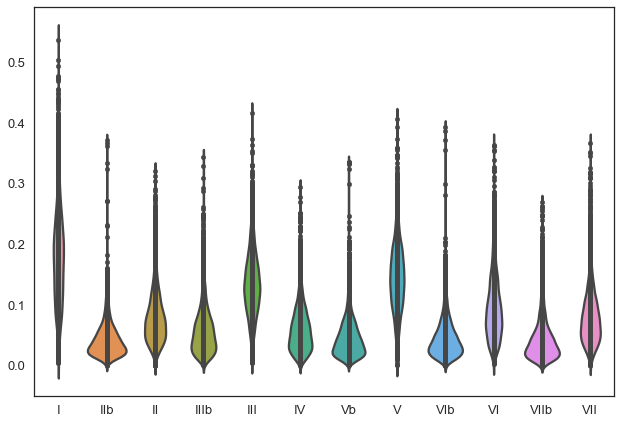

In [29]:
sns.violinplot(data=dMaj, inner="point")
plt.show()

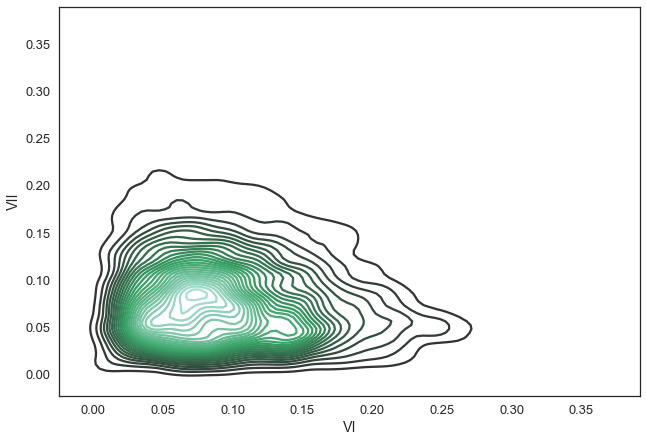

In [30]:
sns.kdeplot(dMaj['VI'], dMaj['VII'], n_levels=30)
plt.show()

1 -352305.084824 True
2 -358970.809581 True
3 -362277.171576 True
4 -363995.514387 True
5 -364467.148051 True
6 -364496.729393 True
7 -365773.040052 True
8 -366493.713885 True
9 -366780.027055 True
10 -367017.214749 True
11 -367459.418519 True
12 -367207.562142 True
13 -366946.187398 True
14 -367008.371158 True
15 -367250.488694 True
16 -366881.246979 True
17 -366699.635009 True
18 -366421.798261 True
19 -367017.298204 True
20 -365635.6207 True
21 -365900.558008 True
22 -365543.047016 True
23 -365421.467326 True
24 -365316.287938 True
25 -365129.588797 True
26 -364434.756903 True
27 -363410.189968 True
28 -364057.111542 True
29 -363634.588965 True
30 -363486.265717 True
31 -363209.594348 True
32 -362994.230911 True
33 -362135.182475 True
34 -362705.522732 True
35 -361590.591609 True
36 -361421.997832 True
37 -361727.49319 True
38 -360745.562901 True
39 -360126.496024 True
40 -359805.282446 True
41 -359313.895884 True
42 -359122.848836 True
43 -358924.725882 True
44 -358629.400628 True


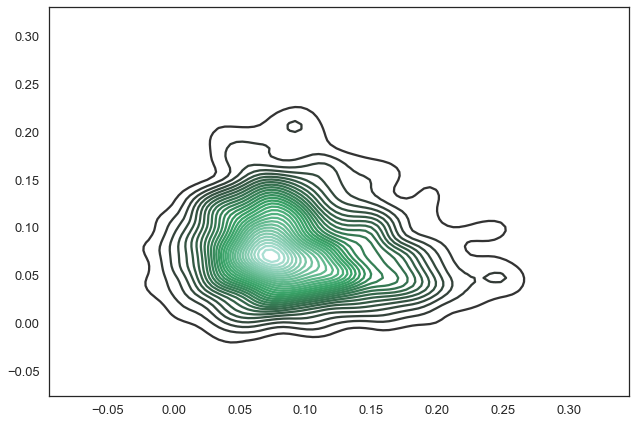

In [31]:
gm = fitMixture(dMaj.values, max_components=100)
#gm = GaussianMixture(
#    n_components=96, covariance_type='full',
#    max_iter=200,
#    random_state = 8)
#gm.fit(dMaj.values)
gmMaj = gm
print gm.converged_
print gm.bic(dMaj)
print gm.weights_

samples = np.asarray(gm.sample(1000)[0])
samples[:,[9, 11]].shape
sns.kdeplot(samples[:,[9, 11]], n_levels=30)
plt.show()

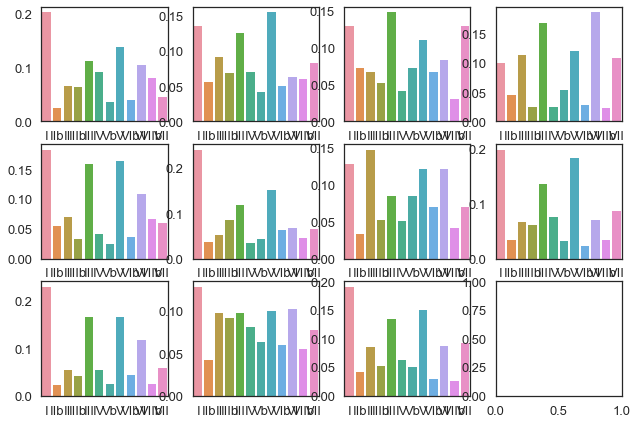

,I,IIb,II,IIIb,III,IV,Vb,V,VIb,VI,VIIb,VII
0,0.201781,0.024603,0.065137,0.064381,0.112526,0.091960,0.035179,0.137319,0.038699,0.103832,0.080009,0.044574
1,0.135039,0.055796,0.091768,0.069243,0.125295,0.070743,0.042126,0.154737,0.050298,0.062479,0.059751,0.082726
2,0.129601,0.072858,0.066658,0.051388,0.147789,0.041471,0.071976,0.109866,0.066499,0.083090,0.029672,0.129132
3,0.099533,0.045086,0.113557,0.024508,0.169616,0.024952,0.053903,0.121665,0.027849,0.186996,0.023127,0.109208
4,0.182999,0.055029,0.069280,0.032415,0.159599,0.041986,0.024476,0.163518,0.035641,0.108927,0.065664,0.060465
5,0.240139,0.035550,0.051178,0.084478,0.118187,0.033382,0.043109,0.151277,0.063103,0.067943,0.046021,0.065632
6,0.127667,0.033250,0.147027,0.051557,0.085082,0.050595,0.084644,0.120914,0.069337,0.120447,0.040558,0.068923
7,0.198202,0.034166,0.065830,0.061835,0.135390,0.076415,0.032173,0.182453,0.022630,0.070200,0.034157,0.086548
8,0.229604,0.022919,0.054717,0.041414,0.166144,0.053217,0.024067,0.165157,0.044222,0.116952,0.024092,0.057496
9,0.128734,0.042498,0.097496,0.092337,0.097256,0.081822,0.063917,0.100444,0.060357,0.102530,0.055063,0.077546


In [35]:
fig, ax = plt.subplots(nrows=3,ncols=4)
ax = np.reshape(np.array(ax), (1, np.size(ax)))[0]


for i in range(len(gm.means_)):
  sns.barplot(degrees,gm.means_[i], ax=ax[i])

plt.show()

df = pd.DataFrame(gm.means_, columns=degrees)
df

# Minor

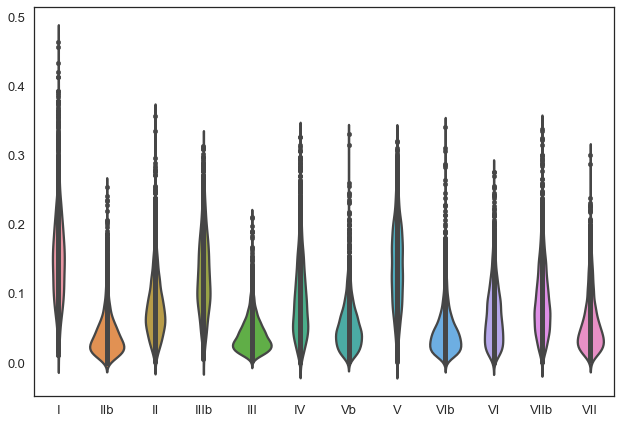

In [36]:
sns.violinplot(data=dMin, inner="point")
plt.show()

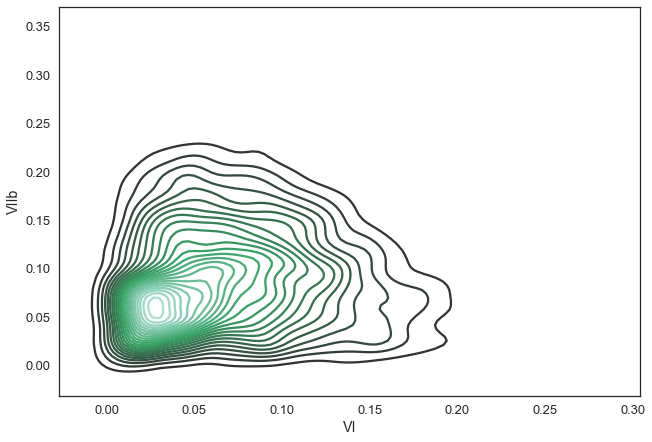

In [37]:
sns.kdeplot(dMin['VI'], dMin['VIIb'], n_levels=30)
plt.show()

1 -167560.761097 True
2 -170856.317673 True
3 -172661.371814 True
4 -173199.972167 True
5 -173631.876614 True
6 -173113.634028 True
7 -173494.945632 True
8 -174032.709731 True
9 -173962.660847 True
10 -173490.088001 True
11 -173056.804204 True
12 -173013.335071 True
13 -172734.761988 True
14 -172276.024621 True
15 -172158.671488 True
16 -172130.940459 True
17 -171783.842264 True
18 -171269.369124 True
19 -171292.295856 True
20 -170859.558551 True
21 -170435.205265 True
22 -169714.182098 True
23 -169150.049722 True
24 -168917.404649 True
25 -168235.263176 True
26 -168026.075321 True
27 -168105.581711 True
28 -167560.408124 True
29 -167489.627236 True
30 -166413.967778 True
31 -165690.469966 True
32 -165331.064248 True
33 -165563.371793 True
34 -165154.434833 True
35 -164707.230027 True
36 -163290.549821 True
37 -163266.33612 True
38 -163251.418835 True
39 -162531.810064 True
40 -162294.326103 True
41 -161323.227057 True
42 -161425.203093 True
43 -160590.045162 True
44 -160381.5481 True


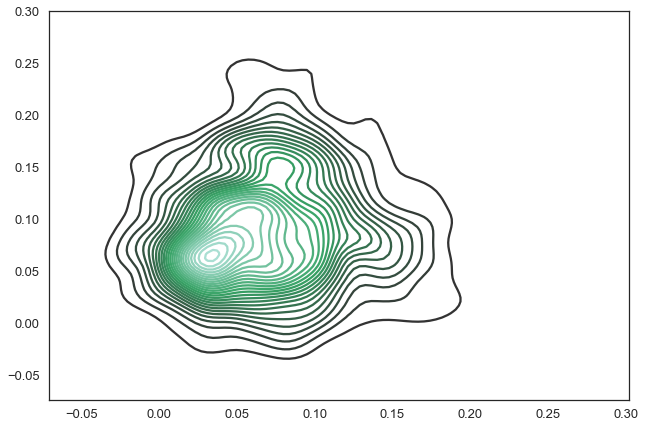

In [38]:
gm = fitMixture(dMin.values, max_components=50)
#gm = GaussianMixture(
#    n_components=147, covariance_type='full',
#    max_iter=200,
#    random_state = 8)
#gm.fit(dMin.values)
gmMin=gm
print gm.converged_
print gm.bic(dMin)
print gm.weights_

samples = np.asarray(gm.sample(1000)[0])
samples[:,[9, 11]].shape
sns.kdeplot(samples[:,[9, 10]], n_levels=30)
plt.show()

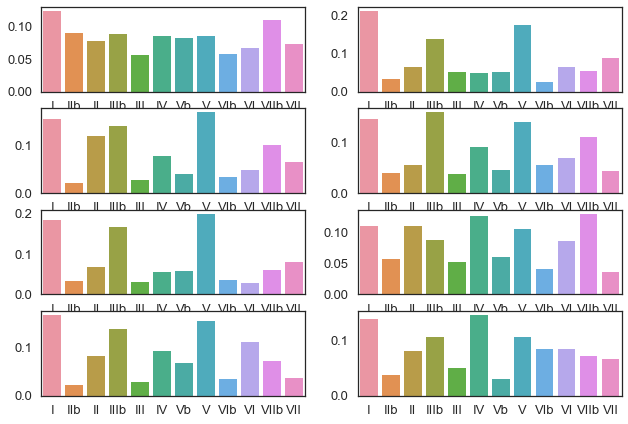

,I,IIb,II,IIIb,III,IV,Vb,V,VIb,VI,VIIb,VII
0,0.124374,0.090640,0.077314,0.089000,0.056628,0.085559,0.082871,0.085601,0.057285,0.067559,0.110156,0.073011
1,0.211090,0.032283,0.063394,0.137833,0.051139,0.048467,0.050147,0.174078,0.026005,0.064192,0.054131,0.087243
2,0.155659,0.021550,0.119323,0.140279,0.027485,0.078531,0.038781,0.169477,0.034080,0.048990,0.100953,0.064891
3,0.147338,0.039011,0.056387,0.160561,0.037015,0.090649,0.046677,0.141554,0.056445,0.069671,0.111356,0.043336
4,0.184672,0.032879,0.068457,0.167285,0.030375,0.056211,0.058073,0.198835,0.035484,0.027578,0.059583,0.080569
5,0.109480,0.056657,0.109429,0.087861,0.052441,0.125676,0.060582,0.105915,0.040157,0.085992,0.129786,0.036025
6,0.165865,0.022072,0.081787,0.137006,0.028019,0.093019,0.067267,0.154289,0.033888,0.110229,0.071029,0.035527
7,0.138774,0.036854,0.080022,0.106510,0.050303,0.145336,0.030277,0.105802,0.085058,0.083896,0.071650,0.065518


In [39]:
fig, ax = plt.subplots(nrows=4,ncols=2)
ax = np.reshape(np.array(ax), (1, np.size(ax)))[0]


for i in range(len(gm.means_)):
  sns.barplot(degrees,gm.means_[i], ax=ax[i])

plt.show()

df = pd.DataFrame(gm.means_, columns=degrees)
df

# Dominant

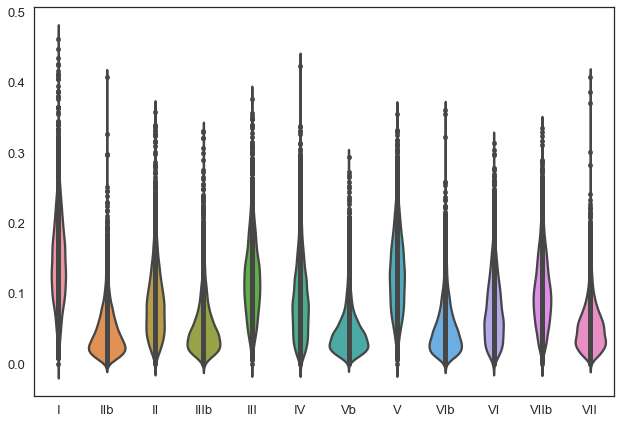

In [40]:
sns.violinplot(data=dDom, inner="point")
plt.show()

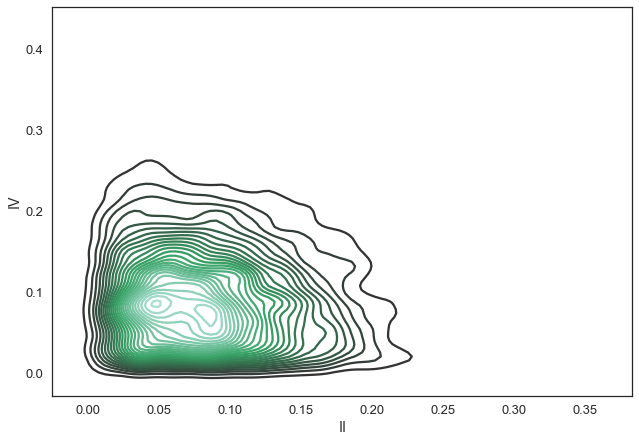

In [41]:
sns.kdeplot(dDom['II'], dDom['IV'], n_levels=30)
plt.show()

1 -361516.624546 True
2 -388984.71841 True
3 -394809.237656 True
4 -397256.33297 True
5 -398727.275578 True
6 -399411.250442 True
7 -399980.925406 True
8 -400091.58873 True
9 -400212.727663 True
10 -400298.276994 True
11 -400097.642298 True
12 -400214.781278 True
13 -400580.472258 True
14 -400005.224219 True
15 -400219.126303 True
16 -399630.559423 True
17 -399516.986394 True
18 -399578.308136 True
19 -399219.416079 True
20 -398997.538646 True
21 -398879.978774 True
22 -398763.756776 True
23 -398227.894049 True
24 -397564.078594 True
25 -397375.95456 True
26 -397299.37628 True
27 -396858.460415 True
28 -396448.766598 True
29 -395754.323697 True
30 -395956.825559 True
31 -394783.938325 True
32 -394600.513476 True
33 -394203.671056 True
34 -393974.473748 True
35 -393347.488664 True
36 -392604.961204 True
37 -392510.201689 True
38 -392272.832607 True
39 -391815.024864 True
40 -391872.002241 True
41 -391403.251983 True
42 -390285.944014 True
43 -390105.348367 True
44 -389368.947925 True
45

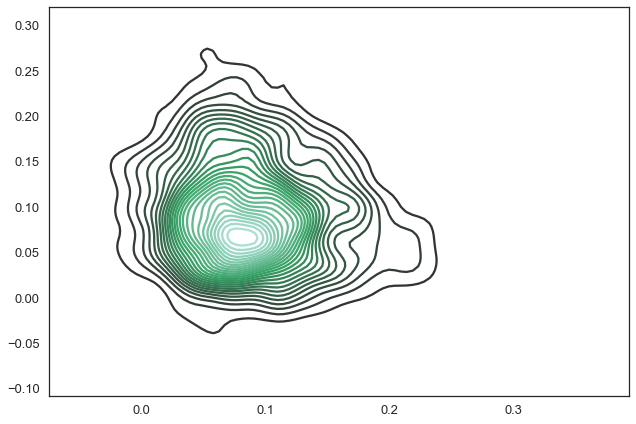

In [42]:
gm = fitMixture(dDom.values, max_components=50)
#gm = GaussianMixture(
#    n_components=109, covariance_type='full',
#    max_iter=200,
#    random_state = 8)
#gm.fit(dDom.values)
gmDom=gm
print gm.converged_
print gm.bic(dDom)
print gm.weights_

samples = np.asarray(gm.sample(1000)[0])
samples[:,[9, 11]].shape
sns.kdeplot(samples[:,[2, 5]], n_levels=30)
plt.show()

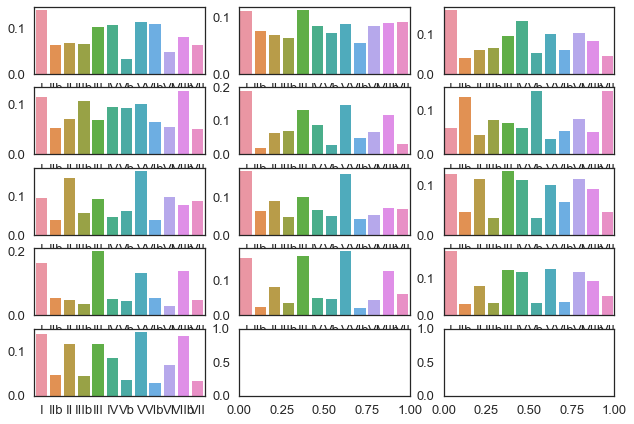

,I,IIb,II,IIIb,III,IV,Vb,V,VIb,VI,VIIb,VII
0,0.140066,0.063408,0.067665,0.066583,0.102397,0.108587,0.033527,0.114144,0.110536,0.048685,0.080894,0.063507
1,0.111071,0.076076,0.068629,0.063504,0.112804,0.084337,0.072351,0.088513,0.054535,0.084965,0.090514,0.092701
2,0.160226,0.041067,0.060919,0.066379,0.094970,0.134003,0.051605,0.100745,0.059884,0.102444,0.082817,0.044941
3,0.114491,0.053399,0.070287,0.107041,0.068926,0.095505,0.092825,0.100441,0.065438,0.054143,0.127498,0.050005
4,0.189409,0.018712,0.065065,0.069322,0.131239,0.087470,0.027759,0.148016,0.048246,0.065255,0.117062,0.032444
5,0.061138,0.132025,0.043878,0.078990,0.072009,0.060830,0.146067,0.036173,0.053747,0.080418,0.051954,0.144793
6,0.093915,0.038765,0.146937,0.056220,0.091098,0.047112,0.062234,0.164326,0.039056,0.097066,0.076634,0.086638
7,0.172288,0.063573,0.092772,0.048632,0.101059,0.068228,0.051160,0.164837,0.042865,0.052495,0.071918,0.070171
8,0.122607,0.045332,0.111789,0.033421,0.127688,0.110402,0.034161,0.099757,0.065749,0.112525,0.090856,0.045713
9,0.165033,0.053384,0.046539,0.036823,0.200322,0.052504,0.043549,0.131815,0.055033,0.029882,0.138574,0.046542


In [43]:
fig, ax = plt.subplots(nrows=5,ncols=3)
ax = np.reshape(np.array(ax), (1, np.size(ax)))[0]


for i in range(len(gm.means_)):
  sns.barplot(degrees,gm.means_[i], ax=ax[i])

plt.show()

df = pd.DataFrame(gm.means_, columns=degrees)
df

# Hdim7

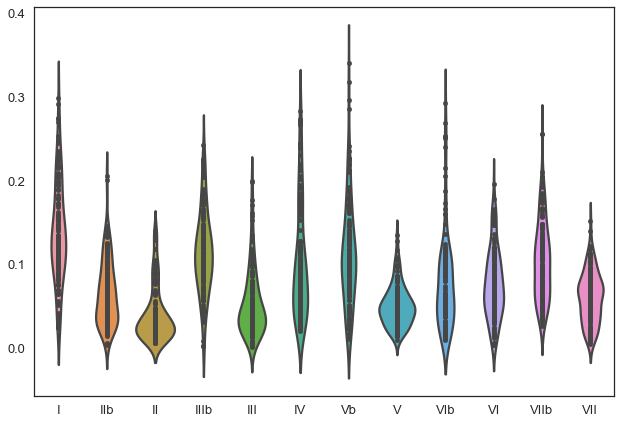

In [44]:
sns.violinplot(data=dHdim, inner="point")
plt.show()

1 -7150.79460173 True
2 -7003.14815143 True
3 -6922.71483471 True
4 -6729.43994085 True
5 -6803.52472978 True
6 -6772.15549792 True
7 -6501.99851233 True
8 -6444.8562837 True
9 -6283.76759421 True
10 -6111.65811125 True
11 -5953.79691793 True
12 -5723.84732736 True
13 -5525.12100411 True
14 -5431.23082107 True
15 -5320.09519492 True
16 -5111.14738254 True
17 -5041.24626023 True
18 -4792.55872833 True
19 -4508.83037717 True
20 -4252.48206939 True
21 -4045.84121312 True
22 -3913.04604564 True
23 -3718.09710428 True
24 -3587.97295724 True
25 -3364.22734277 True
26 -3021.18487653 True
27 -2663.7221975 True
28 -2493.07424317 True
29 -2333.93826429 True
30 -1992.16751998 True
31 -1659.78997702 True
32 -1491.77721317 True
33 -1170.42304997 True
34 -854.894717176 True
35 -458.416318101 True
36 -58.9899221725 True
37 290.81548447 True
38 688.367574838 True
39 998.630450218 True
40 1143.94895851 True
41 1546.15127976 True
42 1973.13764402 True
43 2401.19832055 True
44 2807.87370907 True
45 3181.

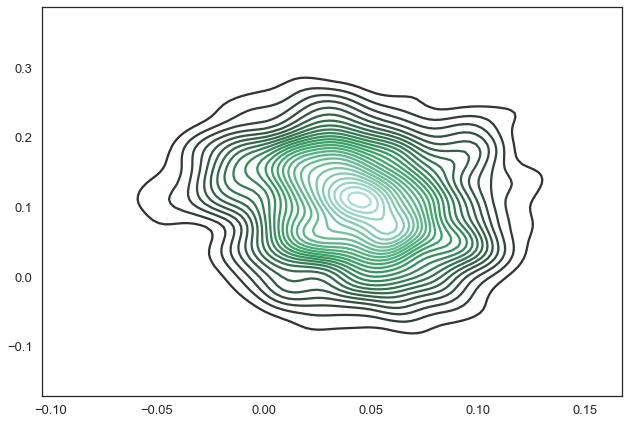

In [45]:
gm = fitMixture(dHdim.values, max_components=50)
#gm = GaussianMixture(
#    n_components=30, covariance_type='full',
#    max_iter=200,
#    random_state = 8)
#gm.fit(dHdim.values)
gmHdim=gm
print gm.converged_
print gm.bic(dHdim.values)
print gm.weights_

samples = np.asarray(gm.sample(1000)[0])
samples[:,[9, 11]].shape
sns.kdeplot(samples[:,[2, 5]], n_levels=30)
plt.show()

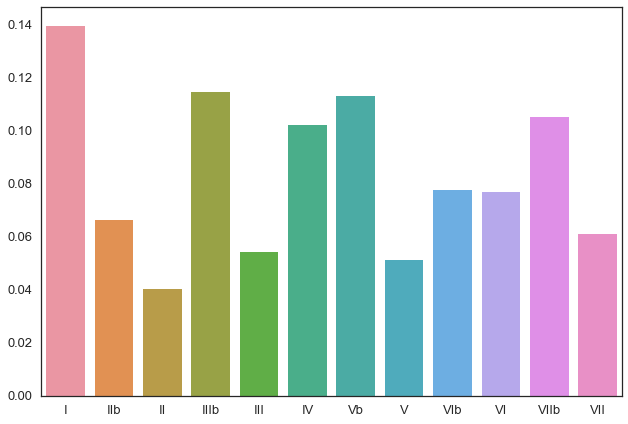

,I,IIb,II,IIIb,III,IV,Vb,V,VIb,VI,VIIb,VII
0,0.13941,0.066287,0.040154,0.114287,0.054254,0.102019,0.112841,0.050935,0.07733,0.076695,0.104872,0.060917


In [47]:
fig, ax = plt.subplots(nrows=1,ncols=1)
ax = np.reshape(np.array(ax), (1, np.size(ax)))[0]


for i in range(len(gm.means_)):
  sns.barplot(degrees,gm.means_[i], ax=ax[i])

plt.show()

df = pd.DataFrame(gm.means_, columns=degrees)
df

# Dim

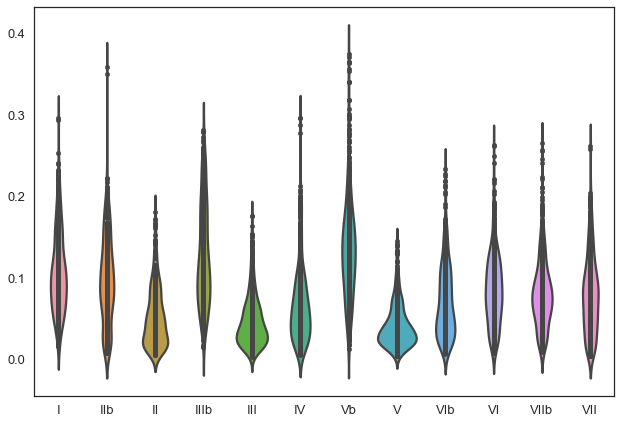

In [48]:
sns.violinplot(data=dDim, inner="point")
plt.show()

1 -28209.2561917 True
2 -28676.9020561 True
3 -28577.2691556 True
4 -28532.3715427 True
5 -28496.3524199 True
6 -28380.7807358 True
7 -28039.8861295 True
8 -27822.3352684 True
9 -27556.7803923 True
10 -27165.0154567 True
11 -27152.3926558 True
12 -26982.2572759 True
13 -26517.3184955 True
14 -26359.8497331 True
15 -26004.5210486 True
16 -25657.8161769 True
17 -25492.1730351 True
18 -25056.8800255 True
19 -24717.1446769 True
20 -24543.3438065 True
21 -24083.2381898 True
22 -23702.4457087 True
23 -23409.036623 True
24 -23222.1221895 True
25 -22917.4163914 True
26 -22614.3535939 True
27 -22384.7805747 True
28 -22218.5465789 True
29 -21689.3966559 True
30 -21475.2828089 True
31 -21189.8319337 True
32 -20884.7017237 True
33 -20627.9455023 True
34 -20195.3723585 True
35 -19995.0364691 True
36 -19741.4881508 True
37 -19608.7321603 True
38 -19239.9979281 True
39 -18945.2526471 True
40 -18796.0208761 True
41 -18546.3725439 True
42 -18132.0155029 True
43 -17773.5157257 True
44 -17636.83552 True


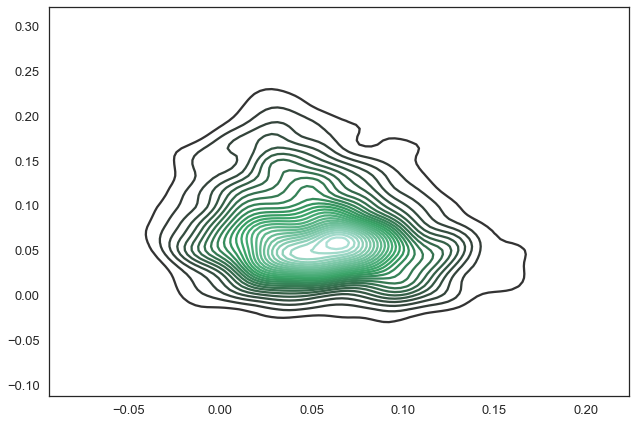

In [49]:
gm = fitMixture(dDim.values, max_components=50)
#gm = GaussianMixture(
#    n_components=55, covariance_type='full',
#    max_iter=200,
#    random_state = 8)
#gm.fit(dDim.values)
gmDim=gm
print gm.converged_
print gm.bic(dDim)
print gm.weights_

samples = np.asarray(gm.sample(1000)[0])
samples[:,[9, 11]].shape
sns.kdeplot(samples[:,[2, 5]], n_levels=30)
plt.show()

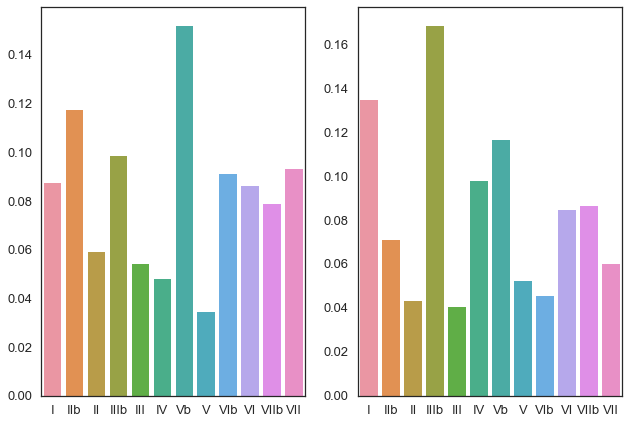

,I,IIb,II,IIIb,III,IV,Vb,V,VIb,VI,VIIb,VII
0,0.087476,0.117310,0.059024,0.098613,0.053927,0.048021,0.151997,0.034415,0.091155,0.086248,0.078809,0.093006
1,0.134731,0.070663,0.043209,0.168394,0.040191,0.097791,0.116503,0.052259,0.045456,0.084586,0.086235,0.059984


In [50]:
fig, ax = plt.subplots(nrows=1,ncols=2)
ax = np.reshape(np.array(ax), (1, np.size(ax)))[0]


for i in range(len(gm.means_)):
  sns.barplot(degrees,gm.means_[i], ax=ax[i])

plt.show()

df = pd.DataFrame(gm.means_, columns=degrees)
df

In [51]:
def chordScore(chroma):
    norm = logsumexp([gmMaj.score_samples(chroma) + np.log(np.array([float(len(dMaj))/len(chromas)])),\
    gmMin.score_samples(chroma) + math.log(float(len(dMin))/len(chromas)),\
    gmDom.score_samples(chroma) + math.log(float(len(dDom))/len(chromas)),\
    gmHdim.score_samples(chroma) + math.log(float(len(dHdim))/len(chromas)),\
    gmDim.score_samples(chroma) + math.log(float(len(dDim))/len(chromas))], axis=0)
    return np.array([\
    (gmMaj.score_samples(chroma) + math.log(float(len(dMaj))/len(chromas))) - norm, \
    (gmMin.score_samples(chroma) + math.log(float(len(dMin))/len(chromas))) - norm, \
    (gmDom.score_samples(chroma) + math.log(float(len(dDom))/len(chromas)))  - norm, \
    (gmHdim.score_samples(chroma) + math.log(float(len(dHdim))/len(chromas)))  - norm, \
    (gmDim.score_samples(chroma) + math.log(float(len(dDim))/len(chromas))) - norm])

In [52]:
def correctNum(chromas, classN):
    res=np.exp(chordScore(chromas))
    m = np.max(res, axis=0)
    return np.sum(res[classN] == m)

In [53]:
def accuracy(chromas, classN):
    return float(correctNum(chromas, classN)) / len(chromas) * 100.0

In [54]:
print 'maj', accuracy(dMaj.values, 0)
print 'min', accuracy(dMin.values, 1)
print 'dom', accuracy(dDom.values, 2)
print 'hdim', accuracy(dHdim.values, 3)
print 'dim', accuracy(dDim.values, 4)
print 'total (train error)', float(correctNum(dMaj.values, 0) + correctNum(dMin.values, 1) + correctNum(dDom.values, 2) +correctNum(dHdim.values, 3) + correctNum(dDim.values, 4)) /\
(len(dMaj.values) + len(dMin.values) + len(dDom.values) + len(dHdim.values) + len(dDim.values)) * 100

maj 81.6385822196
min 80.1072066706
dom 81.3263076725
hdim 40.0
dim 80.0347222222
total 80.8523121233


In [55]:
chromas[0]

array([ 0.03166625,  0.07464851,  0.03824636,  0.15397081,  0.02247348,
        0.01862632,  0.16934241,  0.01058287,  0.01385677,  0.14309676,
        0.02654827,  0.29694119], dtype=float32)

# Check artificial binary patterns (min7 classified as dominant, the rest is Ok)

In [68]:
print 'maj7', np.exp(chordScore([[0.25, 0, 0, 0, 0.25, 0, 0, 0.25, 0, 0, 0.0, 0.25]]))
print 'maj', np.exp(chordScore([[0.33, 0, 0, 0, 0.33, 0, 0, 0.33, 0, 0, 0.0, 0.0]]))
print 'maj6', np.exp(chordScore([[0.25, 0, 0, 0, 0.25, 0, 0, 0.25, 0, 0.25, 0.0, 0.0]]))
print 'min7', np.exp(chordScore([[0.25, 0, 0, 0.25, 0.0, 0, 0, 0.25, 0, 0, 0.25, 0.0]]))
print 'hdim7', np.exp(chordScore([[0.25, 0, 0, 0.25, 0.0, 0, 0.25, 0.0, 0, 0, 0.25, 0.0]]))
print 'dim', np.exp(chordScore([[0.33, 0, 0, 0.33, 0.0, 0, 0.33, 0.0, 0, 0, 0.0, 0.0]]))

maj7 [[  9.99964889e-01]
 [  6.94317307e-11]
 [  3.51105683e-05]
 [  2.96541106e-25]
 [  3.07142901e-29]]
maj [[  9.95904993e-01]
 [  1.70018768e-12]
 [  4.09500693e-03]
 [  2.11813838e-46]
 [  2.77516490e-49]]
maj6 [[  9.82783484e-01]
 [  1.65190721e-12]
 [  1.72165165e-02]
 [  3.97589007e-37]
 [  1.63250616e-33]]
min7 [[  5.73109568e-03]
 [  9.93673295e-01]
 [  5.95609066e-04]
 [  1.59019490e-14]
 [  1.70402385e-16]]
hdim7 [[  5.02363530e-12]
 [  8.71387002e-01]
 [  9.36631966e-05]
 [  1.28519217e-01]
 [  1.18168823e-07]]
dim [[  8.14716773e-13]
 [  1.00200088e-13]
 [  2.43366723e-15]
 [  8.07812531e-14]
 [  1.00000000e+00]]


# Check guitar chords

In [69]:
chromas, labels, kinds, mbids, start_times, durations = chordUtils.loadDatasetChroma('../guitar35.npz')
chromas = logNormalize(chromas)
a = np.exp(chordScore(chromas))
m = np.max(a, axis=0)
print "accuracy for major triads played on guitar: ", np.sum(a[0] == m) * 100.0 / chromas.shape[0], '%'

accuracy for major triads played on guitar:  64.5833333333 %


# SVM (just for example)

In [72]:
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from scipy.misc import logsumexp
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn import linear_model, datasets
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

clf = svm.SVC(C=11, kernel = 'rbf', gamma=1.0)
clf.fit(chromas, kinds)
print "Train error:", clf.score(chromas, kinds) * 100.0, '%'


clf = svm.SVC(C=11, kernel = 'rbf', gamma=1.0)
#clf.fit(chromas, kinds)
#clf.score(chromas, kinds)
kf = KFold(n_splits=10, shuffle=True)
svm_scores = cross_val_score(clf, chromas, kinds, cv=kf, n_jobs=-1)
# 90% cross validation. (79% with normalization)
score = svm_scores.mean()
print "Test error (on crossvalidation):", score * 100.0, '%'

Train error: 98.9583333333 %
Test error (on crossvalidation): 96.7777777778 %
